# Imports

In [126]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from imblearn.over_sampling import SMOTENC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import optuna
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.inspection import PartialDependenceDisplay

In [127]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Classification Report Generator

In [128]:
def average_classification_reports(reports):
    avg_report = defaultdict(dict)
    keys = reports[0].keys()
    
    for key in keys:
        if isinstance(reports[0][key], dict):  # '0', '1', 'macro avg', etc.
            for metric in reports[0][key]:
                avg_report[key][metric] = np.mean([r[key][metric] for r in reports])
        else:  # 'accuracy'
            avg_report[key] = np.mean([r[key] for r in reports])
    
    return avg_report

# Modelling-1

## Dataset-1

In [129]:
train1=pd.read_csv("/Users/sudhanvasavyasachi/Desktop/Projects/Credit Card Default/Data/engineered_train_1.csv")
test=pd.read_csv("/Users/sudhanvasavyasachi/Desktop/Projects/Credit Card Default/Data/engineered_test_1.csv")

In [130]:
X = train1.drop(columns='next_month_default')
y = train1['next_month_default']

In [131]:
train1.isna().sum().sum()

0

## Assigning Class weights 

In [132]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, weights))
class_weight_dict

{0: 0.6222033418295101, 1: 2.54577056778679}

In [133]:
# Convert to scale_pos_weight for XGBoost (only supports weighting for binary classification)
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]

## XGBoost

In [134]:
# Define XGBoost classifier
model_xgb_1 = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)

In [135]:
# Build pipeline
pipeline_xgb_1 = Pipeline(steps=[
    ('classifier', model_xgb_1)
])

In [136]:
# K-Fold Cross-validation (Stratified)
skf_xbg_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_xbg_1 = []

In [137]:
for fold, (train_idx, val_idx) in enumerate(skf_xbg_1.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_xgb_1.fit(X_train, y_train)
    y_pred = pipeline_xgb_1.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_xbg_1.append(report)

In [138]:
avg_report_xgb_1 = average_classification_reports(reports_xbg_1)
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(avg_report_xgb_1)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8602183502596507,
                     'precision': 0.8756878507576055,
                     'recall': 0.8453129425092042,
                     'support': 3531.0},
              '1': { 'f1-score': 0.47513524592216017,
                     'precision': 0.44571324096239584,
                     'recall': 0.5089223638470451,
                     'support': 863.0},
              'accuracy': 0.7792444242148384,
              'macro avg': { 'f1-score': 0.6676767980909054,
                             'precision': 0.6607005458600006,
                             'recall': 0.6771176531781247,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.7845864160213132,
                                'precision': 0.7912390368629159,
                                'recall': 0.7792444242148384,
                                'support': 4394.0}})


## Random Forest

In [139]:
# similar to model_xgb_1, we can create other models like model_rf_1 for train1 using skf_rf_1
# Define Random Forest classifier
model_rf_1 = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
# Build pipeline for Random Forest
pipeline_rf_1 = Pipeline(steps=[
    ('classifier', model_rf_1)
])
# K-Fold Cross-validation for Random Forest
skf_rf_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_rf_1 = []
for fold, (train_idx, val_idx) in enumerate(skf_rf_1.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_rf_1.fit(X_train, y_train)
    y_pred = pipeline_rf_1.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_rf_1.append(report)
avg_report_rf_1 = average_classification_reports(reports_rf_1)
pp.pprint(avg_report_rf_1)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.9018563624454753,
                     'precision': 0.8468791508197994,
                     'recall': 0.9644859813084112,
                     'support': 3531.0},
              '1': { 'f1-score': 0.3999620574298876,
                     'precision': 0.6645394656900181,
                     'recall': 0.28644264194669755,
                     'support': 863.0},
              'accuracy': 0.8313154301319983,
              'macro avg': { 'f1-score': 0.6509092099376815,
                             'precision': 0.7557093082549087,
                             'recall': 0.6254643116275543,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.803282219243734,
                                'precision': 0.8110668731076915,
                                'recall': 0.8313154301319983,
                                'support': 4394.0}})


## Support Vector Classifier

In [140]:
train1.columns

Index(['marriage', 'sex', 'education', 'limit_bal', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'pay_to_bill_ratio', 'next_month_default', 'avg_bill_amt', 'total_pay',
       'total_bill', 'average_utilization', 'delinquency_score',
       'consistency_score'],
      dtype='object')

In [141]:
numerical_cols = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'pay_to_bill_ratio','avg_bill_amt', 'total_pay',
       'total_bill', 'average_utilization', 'delinquency_score',
       'consistency_score']

In [142]:

categorical_cols = ['marriage']  # one-hot encode this


In [143]:
# Preprocessors
numerical_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

In [144]:
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown='ignore'))
])

In [145]:
# ColumnTransformer: combine both
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [146]:
# Define model_svc_1
model_svc_1 = SVC(class_weight=class_weight_dict, probability=True, random_state=42)
# Build pipeline for SVC
pipeline_svc_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_svc_1)
])
# K-Fold Cross-validation for SVC
skf_svc_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_svc_1 = []
for fold, (train_idx, val_idx) in enumerate(skf_svc_1.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline_svc_1.fit(X_train, y_train)
    y_pred = pipeline_svc_1.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_svc_1.append(report)
avg_report_svc_1 = average_classification_reports(reports_svc_1)
pp.pprint(avg_report_svc_1)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8315316092101405,
                     'precision': 0.8824043068285568,
                     'recall': 0.7862361937128293,
                     'support': 3531.0},
              '1': { 'f1-score': 0.46713644105023305,
                     'precision': 0.3952037346115848,
                     'recall': 0.5712630359212051,
                     'support': 863.0},
              'accuracy': 0.7440145653163405,
              'macro avg': { 'f1-score': 0.6493340251301868,
                             'precision': 0.6388040207200708,
                             'recall': 0.6787496148170171,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.7599628722684016,
                                'precision': 0.7867160742788873,
                                'recall': 0.7440145653163405,
                                'support': 4394.0}})


## Logistic Regression

In [147]:
# Same Way define model_logistic_1
model_logistic_1 = LogisticRegression(class_weight=class_weight_dict, random_state=42, max_iter=1000)
# Build pipeline for Logistic Regression
pipeline_logistic_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_logistic_1)
])
# K-Fold Cross-validation for Logistic Regression
skf_logistic_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_logistic_1 = []
for fold, (train_idx, val_idx) in enumerate(skf_logistic_1.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_logistic_1.fit(X_train, y_train)
    y_pred = pipeline_logistic_1.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_logistic_1.append(report)
avg_report_logistic_1 = average_classification_reports(reports_logistic_1)
pp.pprint(avg_report_logistic_1)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.7509081433488884,
                     'precision': 0.879100711558395,
                     'recall': 0.655395072217502,
                     'support': 3531.0},
              '1': { 'f1-score': 0.41496572750700833,
                     'precision': 0.30915835884327975,
                     'recall': 0.6310544611819235,
                     'support': 863.0},
              'accuracy': 0.6506144742831134,
              'macro avg': { 'f1-score': 0.5829369354279483,
                             'precision': 0.5941295352008374,
                             'recall': 0.6432247666997128,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.6849276461091199,
                                'precision': 0.7671616468353306,
                                'recall': 0.6506144742831134,
                                'support': 4394.0}})


# Modelling 2

In [148]:
smote_nc = SMOTENC(categorical_features=[0], random_state=42)

## Xgboost

In [149]:
# Define XGBoost classifier
model_xgb_2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [150]:
pipeline_xgb_2 = Pipeline(steps=[
    ('classifier', model_xgb_2)
])

In [151]:
# K-Fold Cross-validation (Stratified)
skf_xbg_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_xbg_2 = []

In [152]:
# train the xgb model using 5 fold cv wherin for each fold, we oversample the minority class using SMOTENC
for fold, (train_idx, val_idx) in enumerate(skf_xbg_2.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    # Apply SMOTENC
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    pipeline_xgb_2.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline_xgb_2.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_xbg_2.append(report)

In [153]:
avg_report_xgb_2 = average_classification_reports(reports_xbg_2)
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(avg_report_xgb_2)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8829636950374325,
                     'precision': 0.857107098425064,
                     'recall': 0.9104502973661852,
                     'support': 3531.0},
              '1': { 'f1-score': 0.4341239023832215,
                     'precision': 0.5086319874959389,
                     'recall': 0.3789107763615296,
                     'support': 863.0},
              'accuracy': 0.8060537096040055,
              'macro avg': { 'f1-score': 0.6585437987103272,
                             'precision': 0.6828695429605015,
                             'recall': 0.6446805368638573,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.7948096802307453,
                                'precision': 0.7886651273891434,
                                'recall': 0.8060537096040055,
                                'support': 4394.0}})


## Random Forest

In [154]:
# use k-5 fold stratified cross-validation and then random forest classifier on the train2 dataset
model_rf_2 = RandomForestClassifier(random_state=42)
pipeline_rf_2 = Pipeline(steps=[
    ('classifier', model_rf_2)
])
# K-Fold Cross-validation (Stratified)
skf_rf_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_rf_2 = []

In [155]:
# do the same for random forest classifier as done for xgb classifier
for fold, (train_idx, val_idx) in enumerate(skf_rf_2.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTENC
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    pipeline_rf_2.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline_rf_2.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_rf_2.append(report)

In [156]:
# print accuracy, precision, recall, f1-score for each class and macro avg
avg_report_rf_2 = average_classification_reports(reports_rf_2)
pp_rf = pprint.PrettyPrinter(indent=2)
pp_rf.pprint(avg_report_rf_2)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8814434038727489,
                     'precision': 0.867208181922139,
                     'recall': 0.8961767204757859,
                     'support': 3531.0},
              '1': { 'f1-score': 0.4705799666994793,
                     'precision': 0.5080856804510591,
                     'recall': 0.4384704519119351,
                     'support': 863.0},
              'accuracy': 0.8062812926718251,
              'macro avg': { 'f1-score': 0.6760116852861142,
                             'precision': 0.6876469311865991,
                             'recall': 0.6673235861938606,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.8007481043095875,
                                'precision': 0.7966750187975278,
                                'recall': 0.8062812926718251,
                                'support': 4394.0}})


## Support Vector Classifier

In [157]:
# we will use SVC now with rbf kernel and then k-5 fold stratified cross-validation on the train2 dataset
# remember to use one hot encoder for marriage and standard scaler for numerical columns
model_svc_2 = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
pipeline_svc_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_svc_2)
])
# K-Fold Cross-validation (Stratified)
skf_svc_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_svc_2 = []

In [158]:
# do the same for SVC as done for xgb and rf classifiers
# Note: SVC does not support SMOTENC directly, so we will apply it only to the training data
for fold, (train_idx, val_idx) in enumerate(skf_svc_2.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTENC
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    pipeline_svc_2.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline_svc_2.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_svc_2.append(report)

In [159]:
avg_report_svc_2 = average_classification_reports(reports_svc_2)
pp_svc = pprint.PrettyPrinter(indent=2)
pp_svc.pprint(avg_report_svc_2)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8087226168140871,
                     'precision': 0.8876108828148436,
                     'recall': 0.7427357689039932,
                     'support': 3531.0},
              '1': { 'f1-score': 0.46135889693792825,
                     'precision': 0.36907469867285625,
                     'recall': 0.6152954808806489,
                     'support': 863.0},
              'accuracy': 0.7177059626763769,
              'macro avg': { 'f1-score': 0.6350407568760077,
                             'precision': 0.6283427907438501,
                             'recall': 0.679015624892321,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.7404989276349507,
                                'precision': 0.7857682048643351,
                                'recall': 0.7177059626763769,
                                'support': 4394.0}})


## Logistic Regression

In [160]:
# use logistic regression with k-5 fold stratified cross-validation on the train2 dataset
model_logistic_2 = LogisticRegression(random_state=42, max_iter=1000)
pipeline_logistic_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_logistic_2)
])
# K-Fold Cross-validation (Stratified)
skf_logistic_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_logistic_2 = []

In [161]:
# do the same for logistic regression as for xgb, rf and svc classifiers

for fold, (train_idx, val_idx) in enumerate(skf_logistic_2.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTENC
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    pipeline_logistic_2.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline_logistic_2.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_logistic_2.append(report)
avg_report_logistic_2 = average_classification_reports(reports_logistic_2)
pp_logistic = pprint.PrettyPrinter(indent=2)
pp_logistic.pprint(avg_report_logistic_2)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.757715606669555,
                     'precision': 0.8783283453603083,
                     'recall': 0.6662701784197111,
                     'support': 3531.0},
              '1': { 'f1-score': 0.4164897761181906,
                     'precision': 0.3130303264624515,
                     'recall': 0.6222479721900347,
                     'support': 863.0},
              'accuracy': 0.6576240327719618,
              'macro avg': { 'f1-score': 0.5871026913938728,
                             'precision': 0.5956793359113799,
                             'recall': 0.644259075304873,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.6906974246563944,
                                'precision': 0.7673014472472335,
                                'recall': 0.6576240327719618,
                                'support': 4394.0}})


## Comparision of all Reports

In [162]:
# Now we can compare the average classification reports of all models
models_reports = {
    'XGBoost (train1)': avg_report_xgb_1,
    'Random Forest (train1)': avg_report_rf_1,
    #'SVC (train1)': avg_report_svc_1,
    'Logistic Regression (train1)': avg_report_logistic_1,
    'XGBoost (train2)': avg_report_xgb_2,
    'Random Forest (train2)': avg_report_rf_2,
    #'SVC (train2)': avg_report_svc_2,
    'Logistic Regression (train2)': avg_report_logistic_2
}

In [163]:
# now compare the reports f1 score,recall,precision and accuracy in form of a table
report_df = pd.DataFrame({
    'Model': models_reports.keys(),
    'Accuracy': [round(report['accuracy'],2) for report in models_reports.values()],
    'Precision (1)': [round(report['1']['precision'],2) for report in models_reports.values()],
    'Recall (1)': [round(report['1']['recall'],2) for report in models_reports.values()],
    'F1-Score (1)': [round(report['1']['f1-score'],2) for report in models_reports.values()],
    'Precision (0)': [round(report['0']['precision'],2) for report in models_reports.values()],
    'Recall (0)': [round(report['0']['recall'],2) for report in models_reports.values()],
    'F1-Score (0)': [round(report['0']['f1-score'],2) for report in models_reports.values()]
})
report_df = report_df.sort_values(by='F1-Score (1)', ascending=False).reset_index(drop=True)
report_df

,Model,Accuracy,Precision (1),Recall (1),F1-Score (1),Precision (0),Recall (0),F1-Score (0)
0,XGBoost (train1),0.78,0.45,0.51,0.48,0.88,0.85,0.86
1,Random Forest (train2),0.81,0.51,0.44,0.47,0.87,0.90,0.88
2,XGBoost (train2),0.81,0.51,0.38,0.43,0.86,0.91,0.88
3,Logistic Regression (train2),0.66,0.31,0.62,0.42,0.88,0.67,0.76
4,Logistic Regression (train1),0.65,0.31,0.63,0.41,0.88,0.66,0.75
5,Random Forest (train1),0.83,0.66,0.29,0.40,0.85,0.96,0.90


## Advanced Modelling

## Catboost- Train 1

In [164]:
# use catboost classifier on train1 dataset which uses weighted loss function and 5 fold cv not smotenc
model_catboost_1 = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
pipeline_catboost_1 = Pipeline(steps=[
    ('classifier', model_catboost_1)
])
# K-Fold Cross-validation (Stratified)
skf_catboost_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_catboost_1 = []

In [165]:
for fold, (train_idx, val_idx) in enumerate(skf_catboost_1.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_catboost_1.fit(X_train, y_train)
    y_pred = pipeline_catboost_1.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_catboost_1.append(report)

In [166]:
avg_report_catboost_1 = average_classification_reports(reports_catboost_1)
pp_catboost_1 = pprint.PrettyPrinter(indent=2)
pp_catboost_1.pprint(avg_report_catboost_1)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8978721576207045,
                     'precision': 0.8522751363448636,
                     'recall': 0.9486264514301898,
                     'support': 3531.0},
              '1': { 'f1-score': 0.4256395505233015,
                     'precision': 0.6088424822749522,
                     'recall': 0.3272305909617613,
                     'support': 863.0},
              'accuracy': 0.8265817023213472,
              'macro avg': { 'f1-score': 0.661755854072003,
                             'precision': 0.7305588093099079,
                             'recall': 0.6379285211959755,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.8051236960992985,
                                'precision': 0.8044639437043688,
                                'recall': 0.8265817023213472,
                                'support': 4394.0}})


## Catboost-train2

In [167]:
# fit a catboost model on the train2 dataset
model_catboost_2 = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
# Build pipeline for CatBoost
pipeline_catboost_2 = Pipeline(steps=[
    ('classifier', model_catboost_2)
])
# K-Fold Cross-validation for CatBoost
skf_catboost_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_catboost_2 = []

In [168]:
# make sure to use SMOTENC for oversampling the minority class for each fold for catboost as well
# train the catboost model using 5 fold cv wherin for each fold, we oversample the minority class using SMOTENC
for fold, (train_idx, val_idx) in enumerate(skf_catboost_2.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTENC
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    pipeline_catboost_2.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline_catboost_2.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_catboost_2.append(report)

In [169]:
avg_report_catboost_2 = average_classification_reports(reports_catboost_2)
pp_catboost = pprint.PrettyPrinter(indent=2)
pp_catboost.pprint(avg_report_catboost_2)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8936005343009399,
                     'precision': 0.8566900477608396,
                     'recall': 0.9338431039365618,
                     'support': 3531.0},
              '1': { 'f1-score': 0.4423478543561662,
                     'precision': 0.5717266181184149,
                     'recall': 0.3608342989571263,
                     'support': 863.0},
              'accuracy': 0.821301775147929,
              'macro avg': { 'f1-score': 0.667974194328553,
                             'precision': 0.7142083329396272,
                             'recall': 0.6473387014468441,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.8049726183263519,
                                'precision': 0.800722036886599,
                                'recall': 0.821301775147929,
                                'support': 4394.0}})


In [170]:
# Add CatBoost report to the comparison DataFrame
models_reports['CatBoost (train2)'] = avg_report_catboost_2

## LightGBM-train1

In [171]:
# train model_lgbm_1 on train1 dataset using weighted loss function and 5 fold cv not smotenc
model_lgbm_1 = LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
pipeline_lgbm_1 = Pipeline(steps=[
    ('classifier', model_lgbm_1)
])
# K-Fold Cross-validation (Stratified)
skf_lgbm_1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_lgbm_1 = [] 

In [172]:
for fold, (train_idx, val_idx) in enumerate(skf_lgbm_1.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline_lgbm_1.fit(X_train, y_train)
    y_pred = pipeline_lgbm_1.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_lgbm_1.append(report)

[LightGBM] [Info] Number of positive: 3452, number of negative: 14124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4826
[LightGBM] [Info] Number of data points in the train set: 17576, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196404 -> initscore=-1.408922
[LightGBM] [Info] Start training from score -1.408922
[LightGBM] [Info] Number of positive: 3452, number of negative: 14124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4825
[LightGBM] [Info] Number of data points in the train set: 17576, number of used features: 30
[LightGBM] [Info] [b

In [173]:
avg_report_lgbm_1 = average_classification_reports(reports_lgbm_1)
pp_lgbm_1 = pprint.PrettyPrinter(indent=2)
pp_lgbm_1.pprint(avg_report_lgbm_1)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.854642231763297,
                     'precision': 0.8934350112075228,
                     'recall': 0.8190880770320023,
                     'support': 3531.0},
              '1': { 'f1-score': 0.5128986105998601,
                     'precision': 0.44778960284047253,
                     'recall': 0.6002317497103129,
                     'support': 863.0},
              'accuracy': 0.7761037778789257,
              'macro avg': { 'f1-score': 0.6837704211815785,
                             'precision': 0.6706123070239975,
                             'recall': 0.7096599133711575,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.7875223535056626,
                                'precision': 0.8059083868514089,
                                'recall': 0.7761037778789257,
                                'support': 4394.0}})


In [174]:
# add the lgbm and catboost results to model report for train1
models_reports['CatBoost (train1)'] = avg_report_catboost_1
models_reports['LGBM (train1)'] = avg_report_lgbm_1
# now add it to the report_df
report_df = pd.DataFrame({
    'Model': models_reports.keys(),
    'Accuracy': [round(report['accuracy'], 2) for report in models_reports.values()],
    'Precision (1)': [round(report['1']['precision'], 2) for report in models_reports.values()],
    'Recall (1)': [round(report['1']['recall'], 2) for report in models_reports.values()],
    'F1-Score (1)': [round(report['1']['f1-score'], 2) for report in models_reports.values()],
    'Precision (0)': [round(report['0']['precision'], 2) for report in models_reports.values()],
    'Recall (0)': [round(report['0']['recall'], 2) for report in models_reports.values()],
    'F1-Score (0)': [round(report['0']['f1-score'], 2) for report in models_reports.values()]
})
report_df = report_df.sort_values(by='F1-Score (1)', ascending=False).reset_index(drop=True)

## LightGBM - train2

In [175]:
# fit a lightgbm model on the train2 dataset
# Define LightGBM classifier
model_lightgbm_2 = LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42)
# Build pipeline for LightGBM
pipeline_lightgbm_2 = Pipeline(steps=[
    ('classifier', model_lightgbm_2)
])
# K-Fold Cross-validation for LightGBM
skf_lightgbm_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reports_lightgbm_2 = []

In [176]:
# do the same for lightgbm as for catboost and other models
# train the lightgbm model using 5 fold cv wherin for each fold, we oversample the minority class using SMOTENC
for fold, (train_idx, val_idx) in enumerate(skf_lightgbm_2.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTENC
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    pipeline_lightgbm_2.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline_lightgbm_2.predict(X_val)

    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    reports_lightgbm_2.append(report)

[LightGBM] [Info] Number of positive: 14124, number of negative: 14124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5219
[LightGBM] [Info] Number of data points in the train set: 28248, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14124, number of negative: 14124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5220
[LightGBM] [Info] Number of data points in the train set: 28248, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

In [177]:
avg_report_lightgbm_2 = average_classification_reports(reports_lightgbm_2)
pp_lightgbm = pprint.PrettyPrinter(indent=2)
pp_lightgbm.pprint(avg_report_lightgbm_2)

defaultdict(<class 'dict'>,
            { '0': { 'f1-score': 0.8910304379320445,
                     'precision': 0.8542039718542416,
                     'recall': 0.931180968564146,
                     'support': 3531.0},
              '1': { 'f1-score': 0.42875800761734445,
                     'precision': 0.5541691282062141,
                     'recall': 0.34971031286210896,
                     'support': 863.0},
              'accuracy': 0.8169776968593536,
              'macro avg': { 'f1-score': 0.6598942227746944,
                             'precision': 0.7041865500302278,
                             'recall': 0.6404456407131275,
                             'support': 4394.0},
              'weighted avg': { 'f1-score': 0.8002381968392849,
                                'precision': 0.7952758721573259,
                                'recall': 0.8169776968593536,
                                'support': 4394.0}})


In [178]:
# Add LightGBM report to the comparison DataFrame
models_reports['LightGBM (train2)'] = avg_report_lightgbm_2

In [179]:
# print models_reports in a table format
report_df = pd.DataFrame({
    'Model': models_reports.keys(),
    'Accuracy': [round(report['accuracy'], 2) for report in models_reports.values()],
    'Precision (1)': [round(report['1']['precision'], 2) for report in models_reports.values()],
    'Recall (1)': [round(report['1']['recall'], 2) for report in models_reports.values()],
    'F1-Score (1)': [round(report['1']['f1-score'], 2) for report in models_reports.values()],
    'Precision (0)': [round(report['0']['precision'], 2) for report in models_reports.values()],
    'Recall (0)': [round(report['0']['recall'], 2) for report in models_reports.values()],
    'F1-Score (0)': [round(report['0']['f1-score'], 2) for report in models_reports.values()]
})
report_df = report_df.sort_values(by='F1-Score (1)', ascending=False).reset_index(drop=True)
# Display the final comparison DataFrame

In [180]:
report_df

,Model,Accuracy,Precision (1),Recall (1),F1-Score (1),Precision (0),Recall (0),F1-Score (0)
0,LGBM (train1),0.78,0.45,0.60,0.51,0.89,0.82,0.85
1,XGBoost (train1),0.78,0.45,0.51,0.48,0.88,0.85,0.86
2,Random Forest (train2),0.81,0.51,0.44,0.47,0.87,0.90,0.88
3,CatBoost (train2),0.82,0.57,0.36,0.44,0.86,0.93,0.89
4,XGBoost (train2),0.81,0.51,0.38,0.43,0.86,0.91,0.88
5,CatBoost (train1),0.83,0.61,0.33,0.43,0.85,0.95,0.90
6,LightGBM (train2),0.82,0.55,0.35,0.43,0.85,0.93,0.89
7,Logistic Regression (train2),0.66,0.31,0.62,0.42,0.88,0.67,0.76
8,Logistic Regression (train1),0.65,0.31,0.63,0.41,0.88,0.66,0.75
9,Random Forest (train1),0.83,0.66,0.29,0.40,0.85,0.96,0.90


#### We will continue with the lightgbm model as it gave the best F1-score. We will now tune the threshold

In [181]:
# use the same lightbm model a fresh one to find the best threshold using 5 fold stratified cross-validation with weighted loss function
def find_best_threshold(model, X, y, skf):
    best_threshold = 0.5
    best_f1 = 0.0

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_val)[:, 1]  # Probability of the positive class

        fpr, tpr, thresholds = roc_curve(y_val, y_proba)
        f1_scores = [f1_score(y_val, (y_proba >= t).astype(int)) for t in thresholds]

        max_f1_index = np.argmax(f1_scores)
        if f1_scores[max_f1_index] > best_f1:
            best_f1 = f1_scores[max_f1_index]
            best_threshold = thresholds[max_f1_index]
    # print the best f1 score for this threshold
    print(f"Best F1 Score: {best_f1} at Threshold: {best_threshold}")
    return best_threshold


In [182]:
# Define LightGBM classifier
model_lightgbm_threshold = LGBMClassifier(scale_pos_weight=scale_pos_weight,random_state=42)
# K-Fold Cross-validation (Stratified)
skf_lightgbm_threshold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Find the best threshold
best_threshold = find_best_threshold(model_lightgbm_threshold, X, y, skf_lightgbm_threshold)
print(f"Best threshold for LightGBM: {best_threshold:.4f}")


[LightGBM] [Info] Number of positive: 3452, number of negative: 14124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4826
[LightGBM] [Info] Number of data points in the train set: 17576, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196404 -> initscore=-1.408922
[LightGBM] [Info] Start training from score -1.408922
[LightGBM] [Info] Number of positive: 3452, number of negative: 14124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4825
[LightGBM] [Info] Number of data points in the train set: 17576, number of used features: 30
[LightGBM] [Info] [b

# Final Training of the model using the threshold above

In [183]:
model_final= LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

In [184]:
# fit the lgbm on train dataset and then predict on the test dataset
pipeline_lgbm_final = Pipeline(steps=[
    ('classifier', model_final)
])
pipeline_lgbm_final.fit(X, y)
# Predict on the test dataset


[LightGBM] [Info] Number of positive: 4315, number of negative: 17655
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4833
[LightGBM] [Info] Number of data points in the train set: 21970, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196404 -> initscore=-1.408922
[LightGBM] [Info] Start training from score -1.408922


Pipeline(steps=[('classifier',
                 LGBMClassifier(random_state=42,
                                scale_pos_weight=4.09154113557358))])

## Classification report on the train set

In [185]:
# print report on train dataset
y_proba_lgbm_train = pipeline_lgbm_final.predict_proba(X)[:, 1]
y_pred_lgbm_train = (y_proba_lgbm_train >= best_threshold).astype(int)
report_lgbm_train = classification_report(y, y_pred_lgbm_train, output_dict=True, zero_division=0)
pp_lgbm_train = pprint.PrettyPrinter(indent=2)
pp_lgbm_train.pprint(report_lgbm_train)


{ '0': { 'f1-score': 0.9046371722172649,
         'precision': 0.9197003394592064,
         'recall': 0.8900594732370434,
         'support': 17655.0},
  '1': { 'f1-score': 0.6398521578432438,
         'precision': 0.6025798525798526,
         'recall': 0.6820393974507531,
         'support': 4315.0},
  'accuracy': 0.8492034592626309,
  'macro avg': { 'f1-score': 0.7722446650302544,
                 'precision': 0.7611400960195295,
                 'recall': 0.7860494353438983,
                 'support': 21970.0},
  'weighted avg': { 'f1-score': 0.8526322865994269,
                    'precision': 0.8574165478850411,
                    'recall': 0.8492034592626309,
                    'support': 21970.0}}


## Classification Report on the test set

In [186]:
X_test = test.drop(columns='next_month_default')
y_test = test['next_month_default']
y_proba_test_lgbm = pipeline_lgbm_final.predict_proba(X_test)[:, 1]
y_pred_lgbm_test = (y_proba_test_lgbm >= best_threshold).astype(int)
# Generate classification report for the test dataset
report_lgbm_test = classification_report(y_test, y_pred_lgbm, output_dict=True, zero_division=0)
# Print the classification report for the test dataset
pp_lgbm_test = pprint.PrettyPrinter(indent=2)
pp_lgbm_test.pprint(report_lgbm_test)

{ '0': { 'f1-score': 0.8638330363960295,
         'precision': 0.9012214551248009,
         'recall': 0.8294232649071359,
         'support': 2046.0},
  '1': { 'f1-score': 0.5140781108083561,
         'precision': 0.4477848101265823,
         'recall': 0.603411513859275,
         'support': 469.0},
  'accuracy': 0.7872763419483101,
  'macro avg': { 'f1-score': 0.6889555736021928,
                 'precision': 0.6745031326256916,
                 'recall': 0.7164173893832055,
                 'support': 2515.0},
  'weighted avg': { 'f1-score': 0.7986103484832586,
                    'precision': 0.8166640847454115,
                    'recall': 0.7872763419483101,
                    'support': 2515.0}}


## Post Modelling Analysis

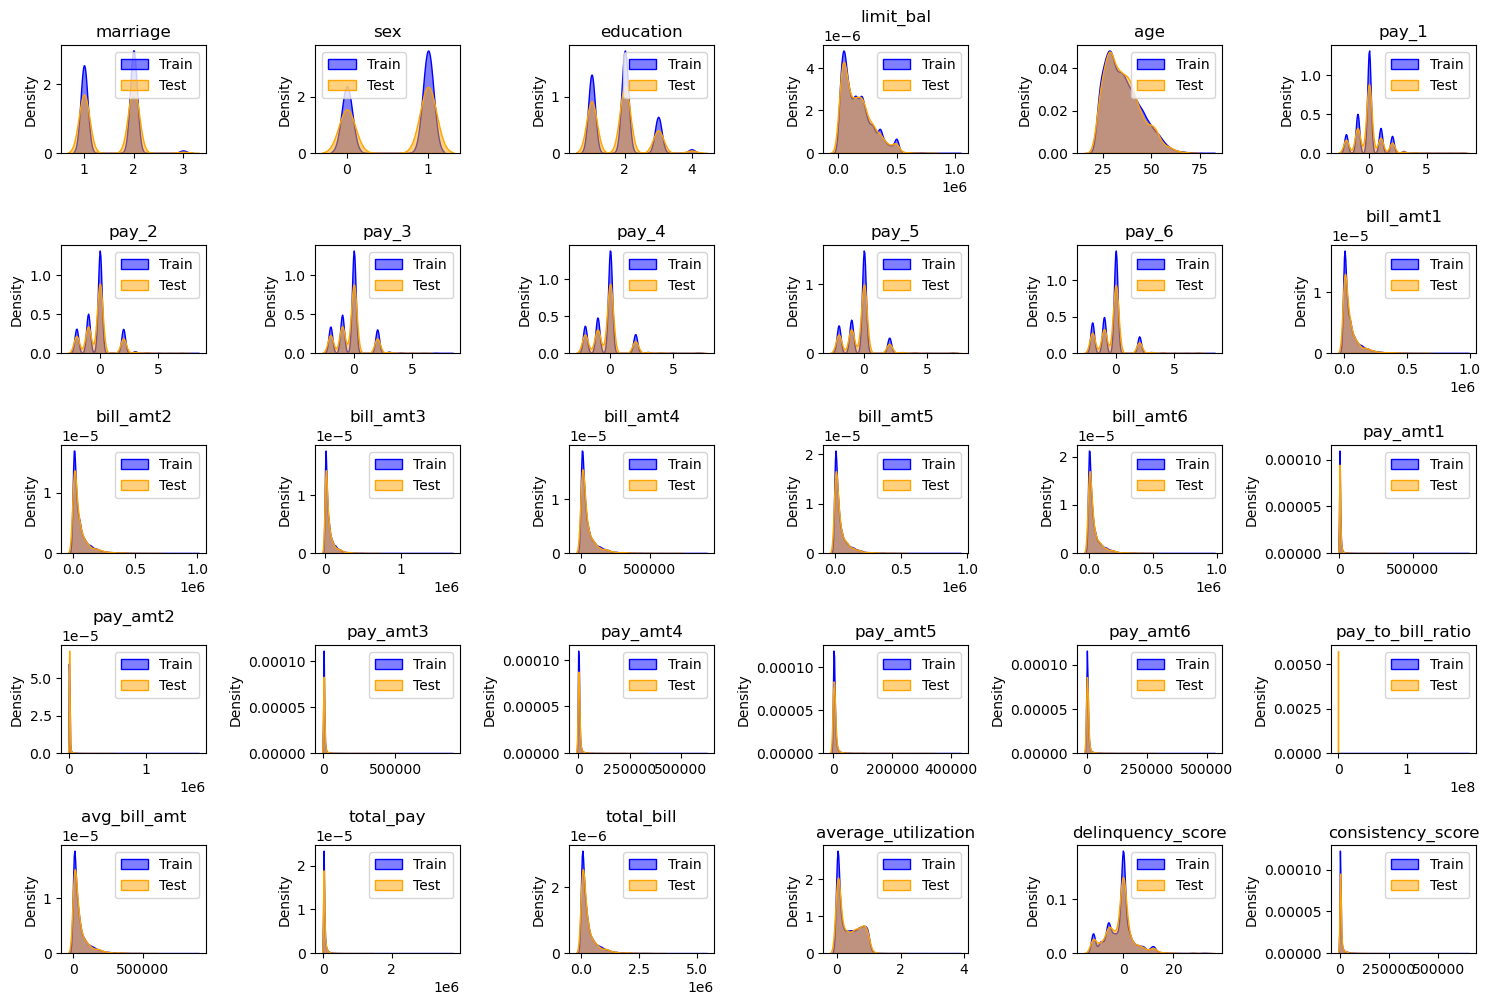

In [187]:
# show the difference in train and test distrbutions of the features plotted side by side
import seaborn as sns
def plot_feature_distributions(train_df, test_df, feature_names):
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(feature_names):
        plt.subplot(5, 6, i + 1) # change this to adjust the number of subplots
        sns.kdeplot(train_df[feature], label='Train', color='blue', fill=True, alpha=0.5)
        sns.kdeplot(test_df[feature], label='Test', color='orange', fill=True, alpha=0.5)
        plt.title(feature)
        plt.xlabel('')
        plt.ylabel('Density')
        plt.legend()
    plt.tight_layout()
    plt.show()
# Plot feature distributions for train and test datasets
plot_feature_distributions(train1,test,test.columns.drop('next_month_default'))


In [188]:
train1['pay_to_bill_ratio'].describe()

count    2.197000e+04
mean     1.988283e+04
std      1.434110e+06
min      0.000000e+00
25%      4.000000e-02
50%      1.100000e-01
75%      6.400000e-01
max      1.892987e+08
Name: pay_to_bill_ratio, dtype: float64

In [189]:
test['pay_to_bill_ratio'].describe()

count    2515.000000
mean       19.399252
std       321.603813
min         0.000000
25%         0.040000
50%         0.110000
75%         0.630000
max      8943.860000
Name: pay_to_bill_ratio, dtype: float64

# ROC-AUC curve

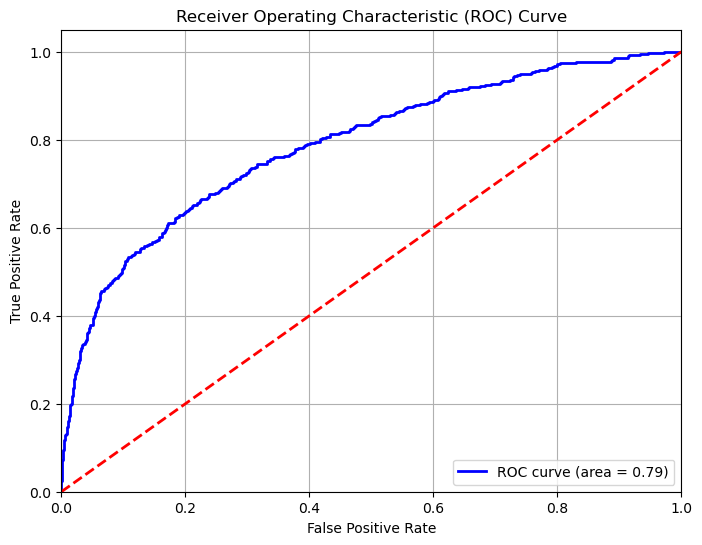

In [190]:
# plot the auc roc curve for the final model on the test dataset
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
# Get predicted probabilities for the positive class
y_scores_lgbm = pipeline_lgbm_final.predict_proba(X_test)[:, 1]
# Plot ROC curve for the final model on the test dataset
plot_roc_curve(y_test, y_scores_lgbm)

## SHAP Analysis

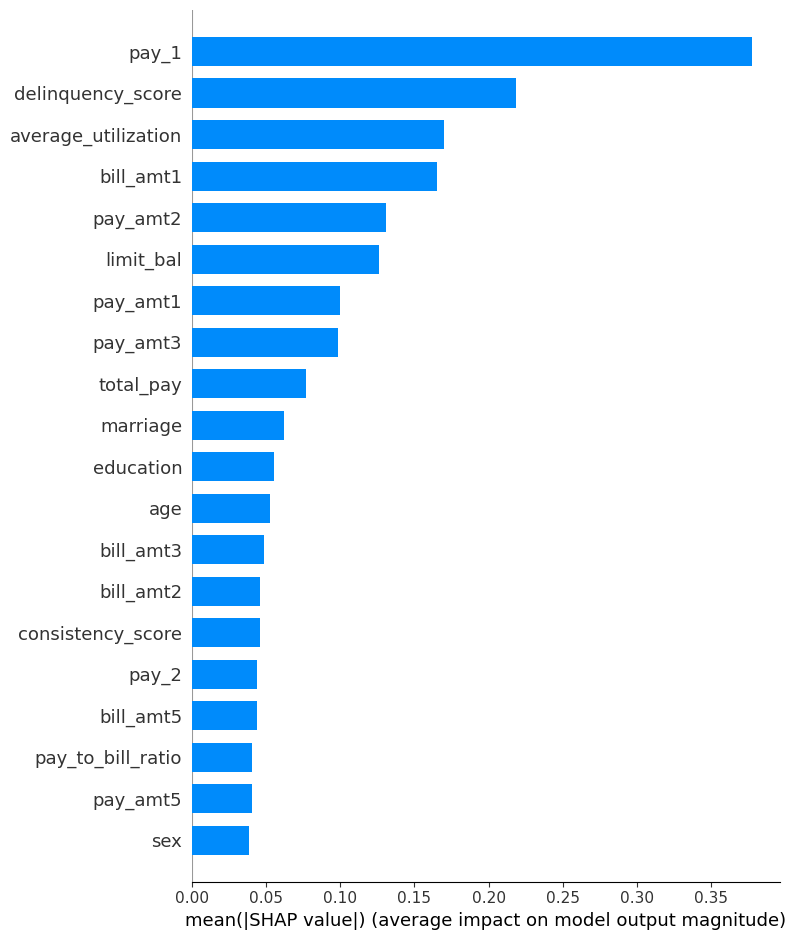

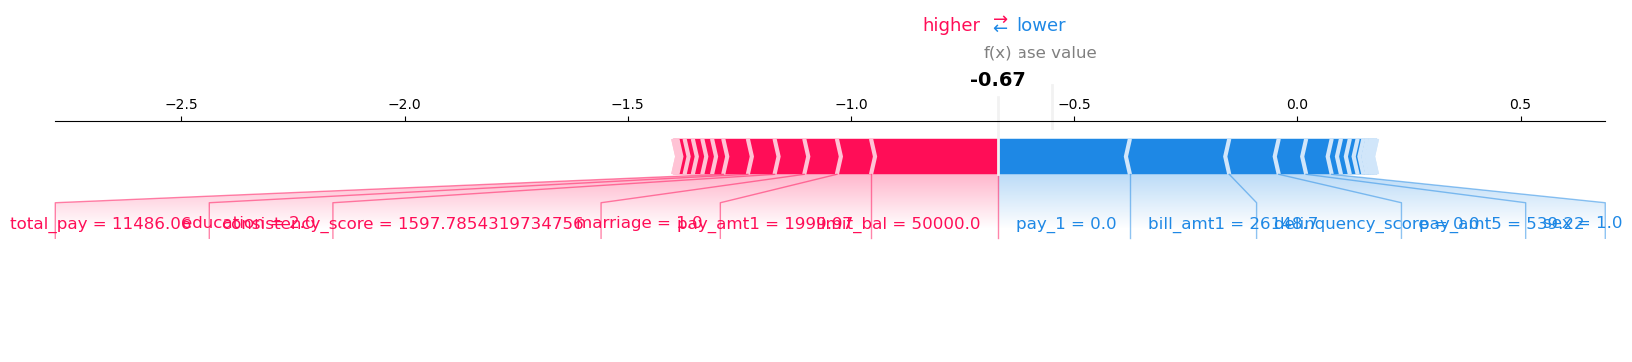

In [191]:
# Perform SHAP analysis on the final model
def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, plot_type="bar")
    
    # Force plot for the first instance
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0], matplotlib=True)
    plt.show()
# Perform SHAP analysis on the final model
shap_analysis(pipeline_lgbm_final.named_steps['classifier'], X_test)

In [192]:
# plot the waterfall plot for the first instance in the test dataset
def plot_waterfall(feature_names, instance_index=0):
    model=pipeline_lgbm_final.named_steps['classifier']
    explainer = shap.Explainer(model)  # or shap.TreeExplainer(model)
    shap_values = explainer(X_train)
    shap.plots.waterfall(shap_values[instance_index],max_display=20)
# Plot waterfall plot for the first instance in the test dataset


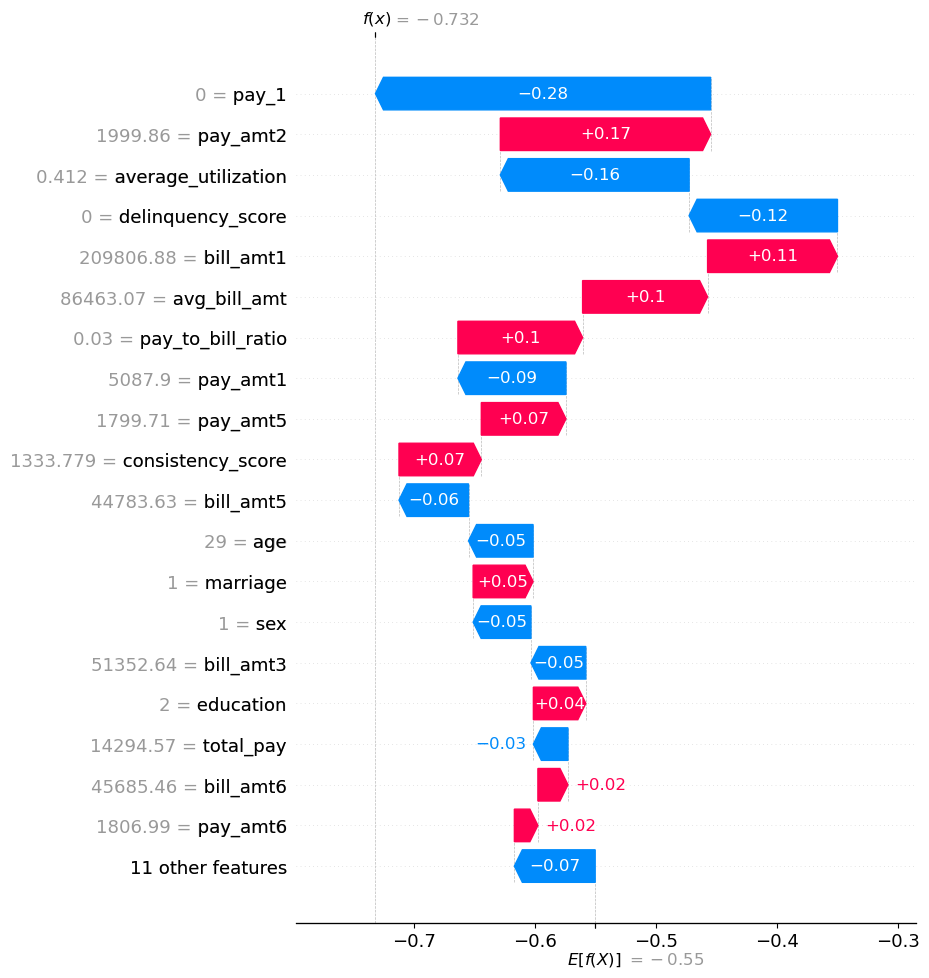

In [193]:
plot_waterfall(X_test.columns, instance_index=0)

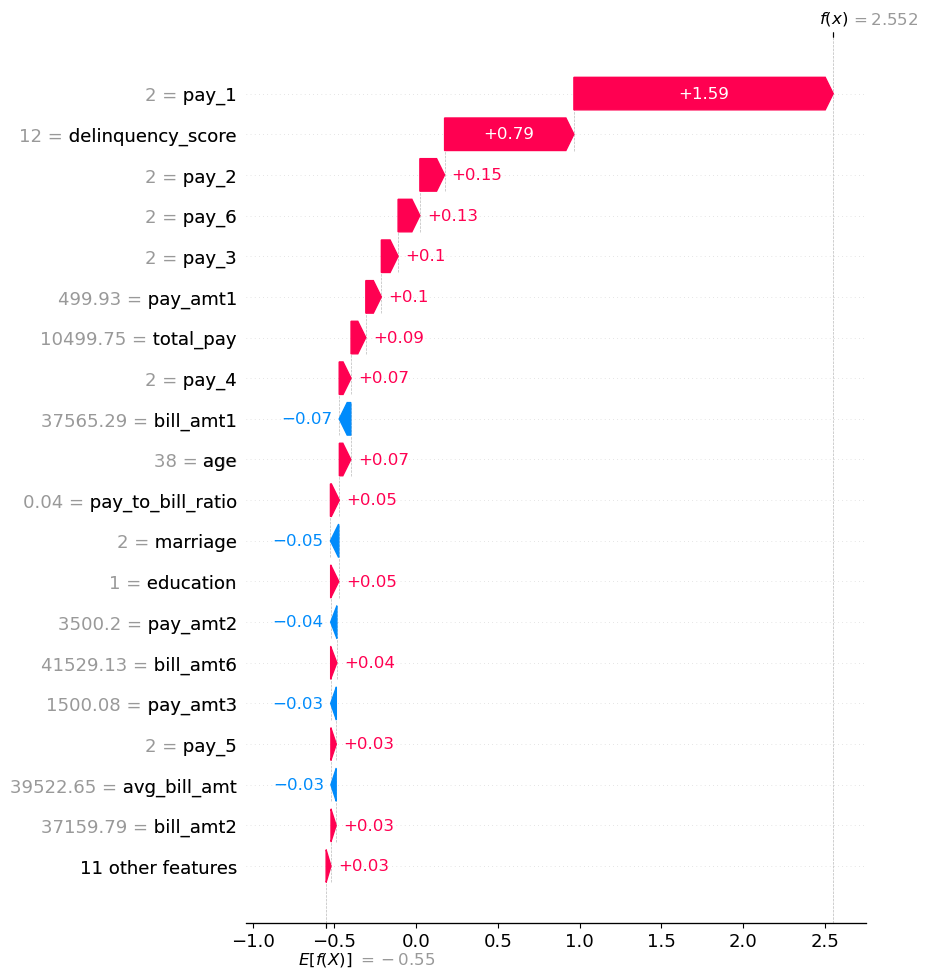

In [194]:
plot_waterfall(X_test.columns, instance_index=24)

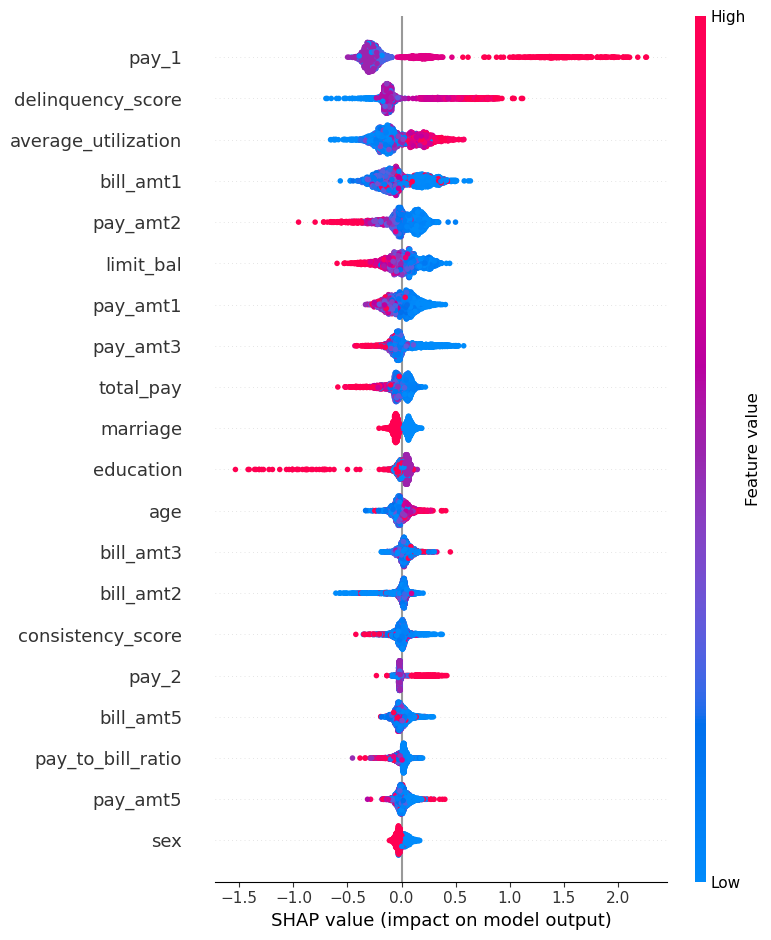

In [195]:
# plot beeswarm plot for the test dataset
def plot_beeswarm(X, shap_values):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, plot_type="dot")
# Get SHAP values for the test dataset
explainer = shap.TreeExplainer(pipeline_lgbm_final.named_steps['classifier'])
shap_values_test = explainer.shap_values(X_test)
# Plot beeswarm plot for the test dataset
plot_beeswarm(X_test, shap_values_test)


In [196]:
X.corr().abs().style.background_gradient(cmap='coolwarm')

,marriage,sex,education,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,pay_to_bill_ratio,avg_bill_amt,total_pay,total_bill,average_utilization,delinquency_score,consistency_score
marriage,1.000000,0.026928,0.135448,0.107386,0.411713,0.018087,0.018803,0.029729,0.028494,0.029754,0.029863,0.030599,0.028528,0.032908,0.028843,0.029200,0.025784,0.001197,0.007189,0.000856,0.012039,0.006287,0.005636,0.007598,0.030939,0.009562,0.030939,0.043404,0.030542,0.000947
sex,0.026928,1.000000,0.017691,0.024053,0.094299,0.049464,0.067834,0.063541,0.062054,0.056468,0.049309,0.032471,0.029899,0.022261,0.019365,0.014026,0.014301,0.002212,0.001591,0.004255,0.001383,0.004203,0.005745,0.006152,0.023767,0.004207,0.023767,0.066929,0.068971,0.012596
education,0.135448,0.017691,1.000000,0.228767,0.181093,0.111447,0.134480,0.122882,0.117745,0.106146,0.087640,0.017614,0.011725,0.006843,0.005105,0.011833,0.014526,0.043187,0.030247,0.039103,0.040006,0.044999,0.042892,0.004834,0.001830,0.068063,0.001830,0.173598,0.134505,0.045791
limit_bal,0.107386,0.024053,0.228767,1.000000,0.146372,0.268870,0.295592,0.284777,0.265120,0.248861,0.232789,0.285491,0.280054,0.283275,0.293889,0.296011,0.293102,0.195215,0.169791,0.208808,0.200504,0.219536,0.217595,0.001069,0.303144,0.345327,0.303144,0.384076,0.315274,0.265951
age,0.411713,0.094299,0.181093,0.146372,1.000000,0.038321,0.051076,0.053296,0.044563,0.051055,0.045866,0.059788,0.057617,0.058343,0.056756,0.054523,0.051483,0.025867,0.022056,0.031092,0.023625,0.021966,0.019550,0.004795,0.059548,0.041441,0.059548,0.039273,0.056171,0.018709
pay_1,0.018087,0.049464,0.111447,0.268870,0.038321,1.000000,0.667664,0.570614,0.535004,0.506336,0.470578,0.188823,0.190642,0.181244,0.180889,0.180425,0.176124,0.075738,0.065288,0.070261,0.061768,0.053826,0.056440,0.016978,0.192862,0.110980,0.192862,0.416615,0.737737,0.093298
pay_2,0.018803,0.067834,0.134480,0.295592,0.051076,0.667664,1.000000,0.765789,0.661297,0.624851,0.577271,0.235238,0.234966,0.223334,0.222744,0.219194,0.216950,0.079327,0.053687,0.050417,0.043601,0.034159,0.036262,0.021693,0.237619,0.086627,0.237619,0.501845,0.850655,0.084975
pay_3,0.029729,0.063541,0.122882,0.284777,0.053296,0.570614,0.765789,1.000000,0.776193,0.687531,0.631671,0.209639,0.238961,0.228455,0.229053,0.224550,0.221582,0.003511,0.062606,0.051046,0.043554,0.030741,0.037007,0.021337,0.236991,0.067033,0.236991,0.490119,0.877739,0.071261
pay_4,0.028494,0.062054,0.117745,0.265120,0.044563,0.535004,0.661297,0.776193,1.000000,0.819872,0.713755,0.205243,0.228329,0.246818,0.249409,0.243946,0.239381,0.006295,0.002058,0.063049,0.041181,0.028972,0.027156,0.021190,0.246859,0.045776,0.246859,0.491416,0.890293,0.056321
pay_5,0.029754,0.056468,0.106146,0.248861,0.051055,0.506336,0.624851,0.687531,0.819872,1.000000,0.813980,0.208945,0.229249,0.244349,0.275921,0.271156,0.262542,0.003464,0.004228,0.015611,0.056852,0.029857,0.024419,0.021305,0.259789,0.026810,0.259789,0.490875,0.877981,0.044142


## Partial Dependency Plots

In [197]:
def plot_partial_dependence(model, X, feature_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(model, X, features=[feature_name], grid_resolution=50, ax=ax)
    plt.title(f'Partial Dependence Plot for {feature_name}')
    plt.show()

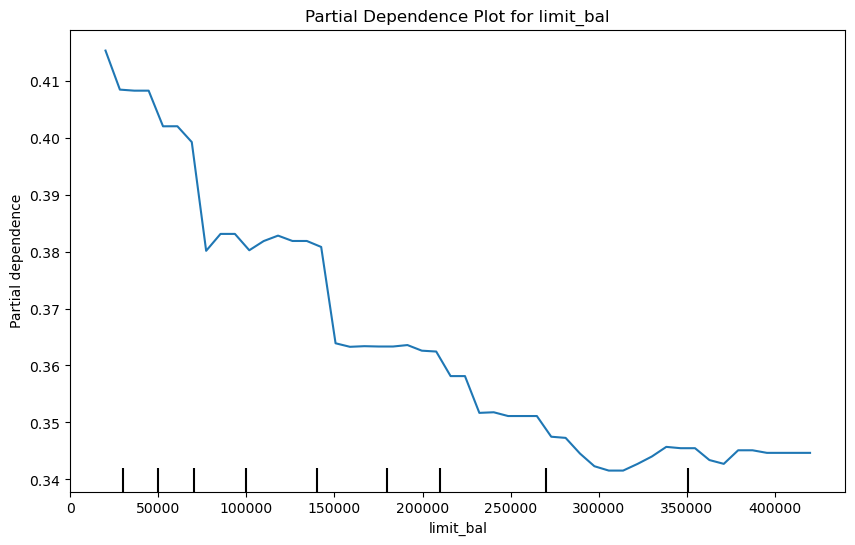

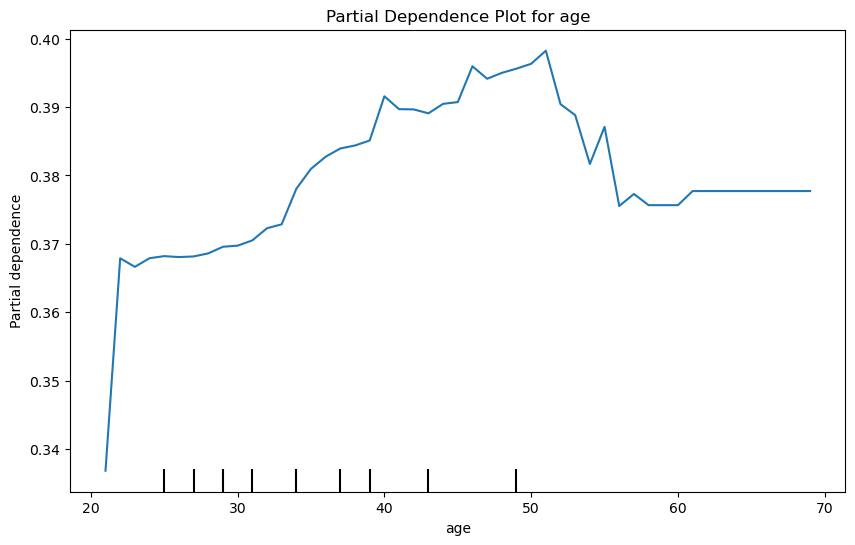

In [198]:
# Plot partial dependence for 'limit_bal'
plot_partial_dependence(pipeline_lgbm_final.named_steps['classifier'], X_test, 'limit_bal')
# Plot partial dependence for 'age'
plot_partial_dependence(pipeline_lgbm_final.named_steps['classifier'], X_test, 'age')

## Final Prediction

In [223]:
final=pd.read_csv('/Users/sudhanvasavyasachi/Desktop/Projects/Credit Card Default/Data/validate_dataset_final.csv')

In [224]:
final.isna().sum().sum()

0

In [225]:
final.columns

Index(['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1',
       'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'AVG_Bill_amt', 'PAY_TO_BILL_ratio'],
      dtype='object')

In [226]:
# lowercase the column names and change pay_0 to pay_1
final.columns = final.columns.str.lower()
final = final.rename(columns={'pay_0': 'pay_1'})

In [227]:
final['total_pay'] = final[[f'pay_amt{i}' for i in range(1, 7)]].apply(lambda x: x.sum(), axis=1)
final['total_bill'] = final[[f'bill_amt{i}' for i in range(1, 7)]].apply(lambda x: x.sum(), axis=1)
final['average_utilization']=final['avg_bill_amt']/final['limit_bal']
delay_cols = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
final['delinquency_score'] = final[delay_cols].sum(axis=1)
pay_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
final['consistency_score'] = final[pay_cols].std(axis=1)

In [228]:
final.columns

Index(['customer_id', 'marriage', 'sex', 'education', 'limit_bal', 'age',
       'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1',
       'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'avg_bill_amt', 'pay_to_bill_ratio', 'total_pay', 'total_bill',
       'average_utilization', 'delinquency_score', 'consistency_score'],
      dtype='object')

In [229]:
# kae predictions on the final dataset. the final does have only the features and not the target variable
X_final = final.drop(['customer_id'],axis=1)
# Predict on the final dataset
y_proba_final = pipeline_lgbm_final.predict_proba(X_final)[:, 1]
# Convert probabilities to binary predictions using the best threshold
y_final_pred = (y_proba_final >= best_threshold).astype(int)
# Save predictions to a CSV file
final['next_month_default'] = y_final_pred

In [230]:
final

,customer_id,marriage,sex,education,limit_bal,age,pay_1,pay_2,pay_3,pay_4,...,pay_amt5,pay_amt6,avg_bill_amt,pay_to_bill_ratio,total_pay,total_bill,average_utilization,delinquency_score,consistency_score,next_month_default
0,1,1,1,2,220000,32,0,0,0,0,...,3000.21,30788.71,23456.33,0.31,43208.62,140738.06,0.106620,0,11591.348629,0
1,2,2,0,1,350000,35,-1,-1,-1,0,...,1565.11,26346.39,13660.33,1.00,82330.60,81960.96,0.039030,-3,14116.320363,0
2,3,2,1,1,310000,39,0,0,0,0,...,10000.16,10000.21,258034.17,0.04,65527.58,1548205.57,0.832368,0,1562.986833,0
3,4,1,0,2,20000,47,0,0,0,2,...,0.02,1000.26,13333.33,0.08,6500.18,79999.46,0.666667,6,1047.597389,1
4,5,2,1,2,500000,30,0,0,0,0,...,8841.07,12000.21,77204.50,0.23,105987.66,463228.27,0.154409,0,14101.872597,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5011,5012,1,0,2,240000,51,0,0,0,0,...,3949.01,3976.22,103737.83,0.04,22854.49,622425.42,0.432241,0,143.600324,1
5012,5013,1,1,3,60000,33,0,0,0,0,...,1099.82,1100.18,41858.83,0.04,10300.23,251149.82,0.697647,0,727.938175,0
5013,5014,1,0,1,290000,36,1,-2,-1,-1,...,1000.05,1000.15,8481.17,0.39,19734.26,50887.46,0.029245,-3,6320.659050,0
5014,5015,1,1,2,120000,28,0,0,0,0,...,2999.95,4000.04,84492.00,0.04,21283.61,506951.39,0.704100,0,810.489394,0


In [231]:
pred=final[['customer_id', 'next_month_default']]

In [232]:
# save the final model to a file
pred.to_csv("validation_predicted.csv",index=False)

In [233]:
pred

,customer_id,next_month_default
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
5011,5012,1
5012,5013,0
5013,5014,0
5014,5015,0


In [222]:
# print the default rate in the final dataset
default_rate = final['next_month_default'].mean()
print(f"Default Rate in Final Dataset: {default_rate:.2%}")

Default Rate in Final Dataset: 28.41%
